# Deep Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Objectdetectie](#Model1)
    - [Ondertiteling van afbeeldinge](#Model2)
    - [Beeldgeneratie](#Model3)
    - [Implementatie](#Model4)
- [Results](#results)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [ ]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install tqdm


In [1]:
# upgrade dataset library
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
!pip install datasets pillow

In [6]:
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import random
import torch
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datasets import load_dataset
import spacy

## Data Overview

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [ ]:
img_train = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train"
img_test = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test"

In [3]:
hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/323 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12437 [00:00<?, ? examples/s]

In [ ]:
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 3 Datasets/submission_example.csv')

In [4]:
hnm_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 12437
    })
})

## Exploratory Data Analysis

### Object detection dataset

#### Train data

In [ ]:
# ImageDataGenerator aanmaken
datagen = ImageDataGenerator(rescale=1./255)  # normaliseer de beelden

# Laad de data automatisch uit submappen
train_data = datagen.flow_from_directory(
    img_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", train_data.class_indices)

Found 2155 images belonging to 2 classes.
Klassen en hun indexen: {'images': 0, 'labels': 1}


#### Test data

In [ ]:
test_data = datagen.flow_from_directory(
    img_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", test_data.class_indices)


Found 537 images belonging to 1 classes.
Klassen en hun indexen: {'images': 0}


## Voorbeeld afbeeldingen

### Train afbeeldingen

In [ ]:
def toon_afbeeldingen_uit_batch(data, num_images):
    """
    Toont een aantal afbeeldingen uit een batch van een ImageDataGenerator.

    Parameters:
    - data: de ImageDataGenerator (flow_from_directory)
    - num_images: het aantal afbeeldingen om te tonen
    """
    # Haal een batch op
    images, labels = next(data)

    # Plot de afbeeldingen
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


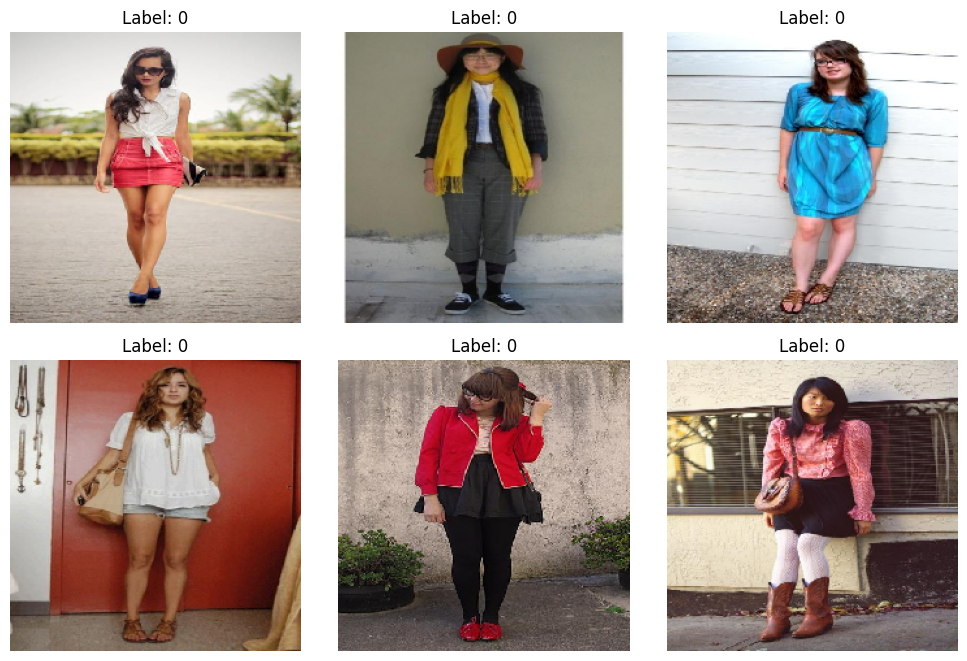

In [ ]:
train_data_show = toon_afbeeldingen_uit_batch(train_data, 6)

### Test afbeeldingen

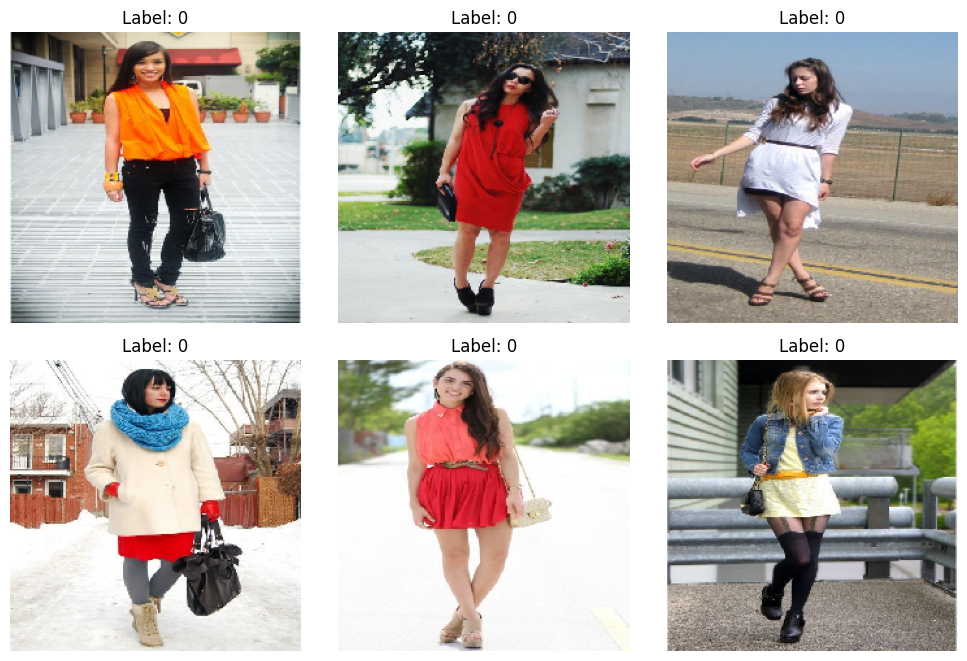

In [ ]:
test_data_show = toon_afbeeldingen_uit_batch(test_data,6)

## Breedte & Hoogte verdeling

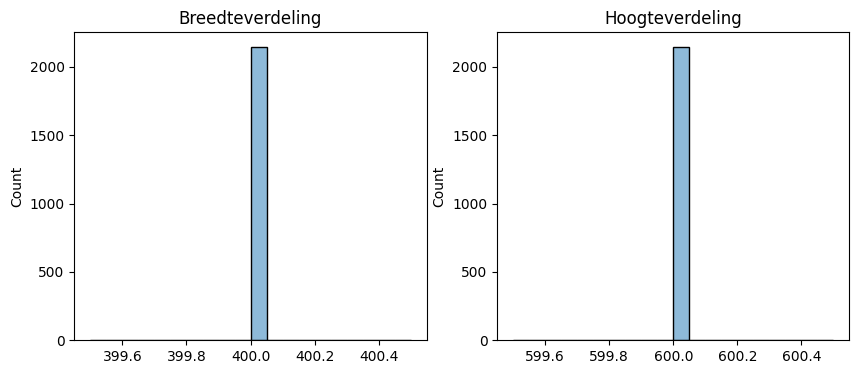

In [ ]:
def verzamel_afmetingen(data):
    sizes = []
    for label in os.listdir(data):
        label_path = os.path.join(data, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)
                    except:
                        continue
    return sizes

afmetingen = verzamel_afmetingen(img_train)

# Visualiseer

widths = [s[0] for s in afmetingen]
heights = [s[1] for s in afmetingen]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Breedteverdeling")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Hoogteverdeling")
plt.show()



De histogrammen laten zien dat bijna alle objecten precies dezelfde breedte en hoogte hebben. De breedte is altijd 400 eenheden en de hoogte is altijd 600 eenheden. Er is vrijwel geen verschil tussen de objecten, want de pieken in de histogrammen zijn heel scherp en geconcentreerd op die waarden.

Dit betekent dat de dataset erg uniform is. Mogelijk zijn de objecten bewust zo gemaakt of geselecteerd met vaste afmetingen, bijvoorbeeld omdat de afbeeldingen allemaal hetzelfde formaat hebben. Het ontbreken van variatie in breedte en hoogte is opvallend en kan invloed hebben op hoe een model leert, omdat het weinig verschillende vormen ziet.

## Controle op corrupte afbeeldingen

In [ ]:
def controleer_corruptie(data):
    fouten = []
    for root, dirs, files in os.walk(data):
        for name in files:
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, name)
                with Image.open(path) as img:
                        img.verify()

    return fouten

corrupt = controleer_corruptie(img_train)
print(f"Corrupt of onleesbare afbeeldingen gevonden: {len(corrupt)}")


Corrupt of onleesbare afbeeldingen gevonden: 0


De code controleert of er beschadigde of onleesbare afbeeldingen in de dataset zitten. Het resultaat geeft aan dat er geen corrupte afbeeldingen zijn gevonden. Dit betekent dat alle beelden goed leesbaar en bruikbaar zijn voor verdere verwerking.

## Voorbeeldbeelden met kleurverdeling

In [ ]:
images_dir = img_train + '/images'

In [ ]:
def toon_images_met_histogram(map_pad, aantal):
    # Pak alle afbeelding-bestanden in de map
    image_files = [f for f in os.listdir(map_pad) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # if len(image_files) < aantal:
    #     print(f"Niet genoeg afbeeldingen in de map ({len(image_files)} gevonden, {aantal} gevraagd).")
    #     return

    # Kies random aantal afbeeldingen
    gekozen = random.sample(image_files, aantal)

    plt.figure(figsize=(12, 4 * aantal))

    for i, fname in enumerate(gekozen):
        path = os.path.join(map_pad, fname)
        img = cv2.imread(path)
        # if img is None:
        #     print(f"Kan {fname} niet laden!")
        #     continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img)

        # Toon afbeelding
        plt.subplot(aantal, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

        # Toon histogram
        plt.subplot(aantal, 2, i*2 + 2)
        plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
        plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
        plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
        plt.title("RGB Histogram")
        plt.xlabel("Pixelwaarde")
        plt.ylabel("Aantal pixels")
        plt.legend()

    plt.tight_layout()
    plt.show()


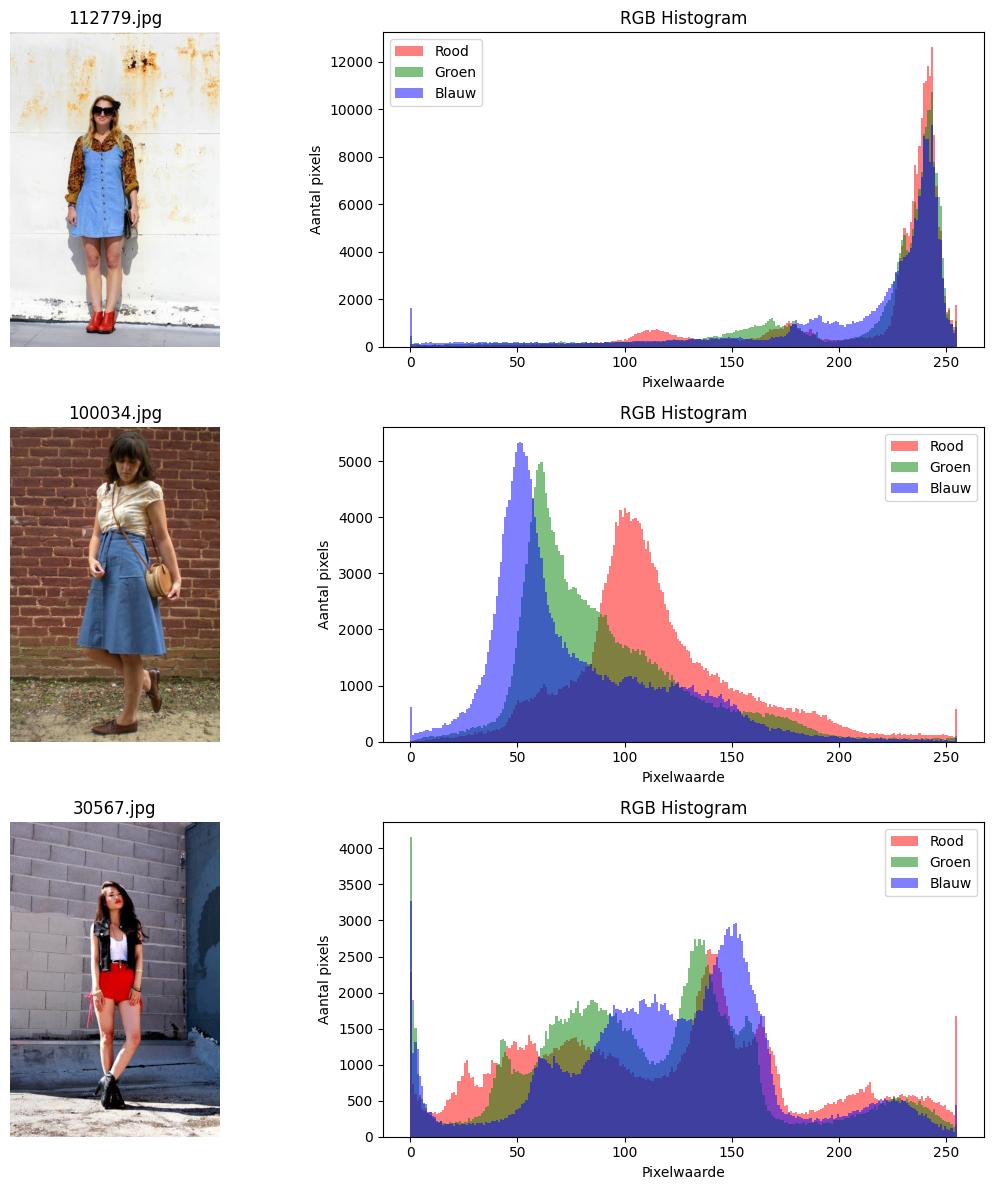

In [ ]:
toon_images_met_histogram(images_dir, 3)


De kleuren verschillen sterk per afbeelding. Dit zie je ook terug in de RGB-histogrammen. Elke afbeelding heeft een andere verdeling van rood, groen en blauw.

Sommige foto's hebben veel heldere kleuren zoals geel en groen, terwijl andere juist warme tinten bevatten zoals rood en bruin. Ook de hoeveelheid licht en schaduw speelt een rol.

De histogrammen laten zien welke kleuren het meest aanwezig zijn in de afbeelding. Hoge pieken in één kleur betekenen dat die kleur veel voorkomt. Als de pieken van rood en groen overlappen, zie je bijvoorbeeld veel geel.

De kleurverdeling is niet altijd gelijk. Elke afbeelding heeft zijn eigen sfeer en dominante kleuren, en dat zie je goed terug in de histogrammen. Dit kan invloed hebben op het model, omdat het model kleuren gebruikt als visuele informatie om objecten te herkennen. Grote kleurverschillen kunnen ervoor zorgen dat het model sommige objecten beter of juist slechter leert herkennen.

### Afbeeldingen met labels

In [ ]:
def toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal):
    # Kies willekeurige afbeeldingen
    alle_afbeeldingen = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    gekozen_afbeeldingen = random.sample(alle_afbeeldingen, min(aantal, len(alle_afbeeldingen)))

    plt.figure(figsize=(6 * aantal, 6))

    for idx, gekozen_afb in enumerate(gekozen_afbeeldingen):
        naam_zonder_ext = os.path.splitext(gekozen_afb)[0]
        label_pad = os.path.join(labels_dir, f"{naam_zonder_ext}.txt")
        image_pad = os.path.join(images_dir, gekozen_afb)

        # Laad de afbeelding
        img = cv2.imread(image_pad)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Lees labelbestand en teken bounding boxes
        if os.path.exists(label_pad):
            with open(label_pad, 'r') as f:
                for line in f:
                    delen = line.strip().split()
                    class_id = int(delen[0])
                    cx, cy, bw, bh = map(float, delen[1:])

                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, class_dict[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Plot afbeelding
        plt.subplot(1, aantal, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(gekozen_afb)

    plt.tight_layout()
    plt.show()

# Klassen
class_dict = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}




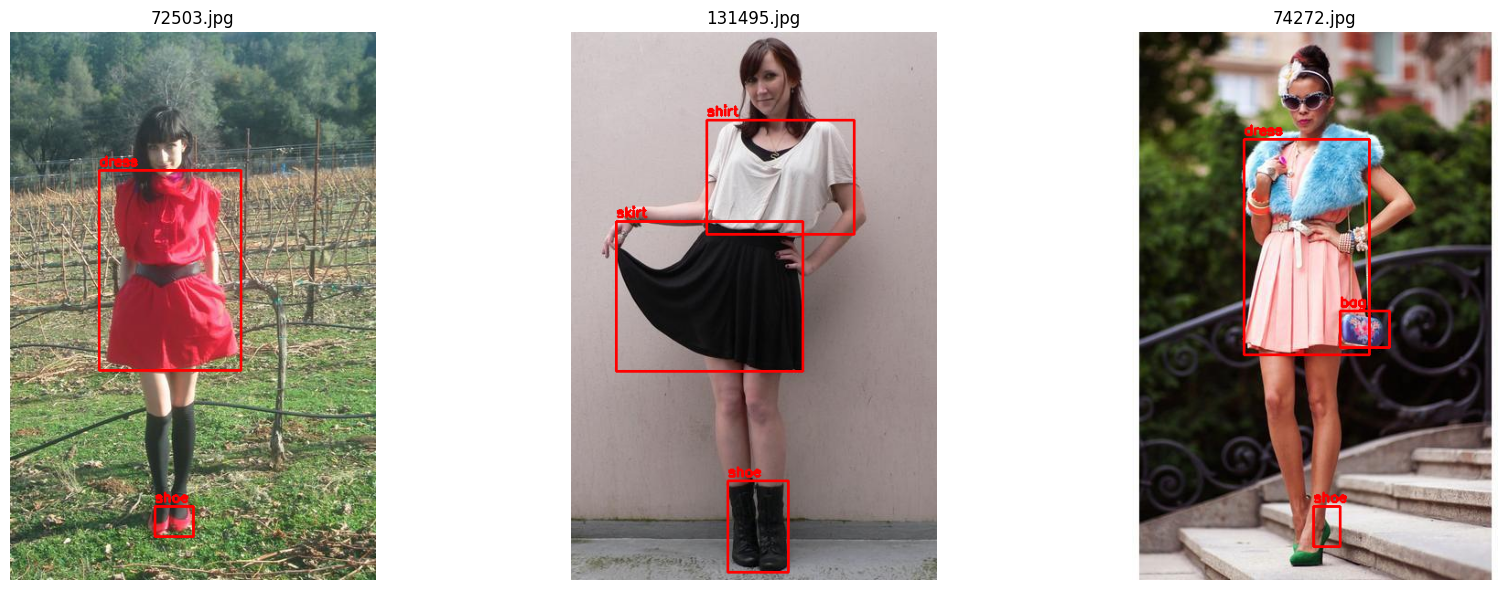

In [ ]:
# Gebruik:
labels_dir = img_train + '/labels'
toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, 3)

De labels zijn over het algemeen goed gedaan voor de kledingstukken en accessoires. De meeste objecten zijn duidelijk en correct gelabeld. Maar bij de schoenen is dat wat minder goed gegaan. Sommige schoenen zijn niet goed zichtbaar op de afbeelding of zijn niet helemaal juist gelabeld.

Dat kan een probleem zijn voor het model. Als de schoenen niet goed gelabeld zijn, wordt het voor het model moeilijker om te leren wat een schoen precies is. Hierdoor kan het model minder goed schoenen herkennen tijdens het testen. Dit kan de nauwkeurigheid van het model negatief beïnvloeden, vooral voor de klasse "schoen", ook al is dat de meest voorkomende klasse in de dataset.

Het is dus belangrijk om ook bij veelvoorkomende klassen te zorgen voor goede en duidelijke labels, zodat het model betrouwbare resultaten kan geven.

### De klassenverdeling in de labels

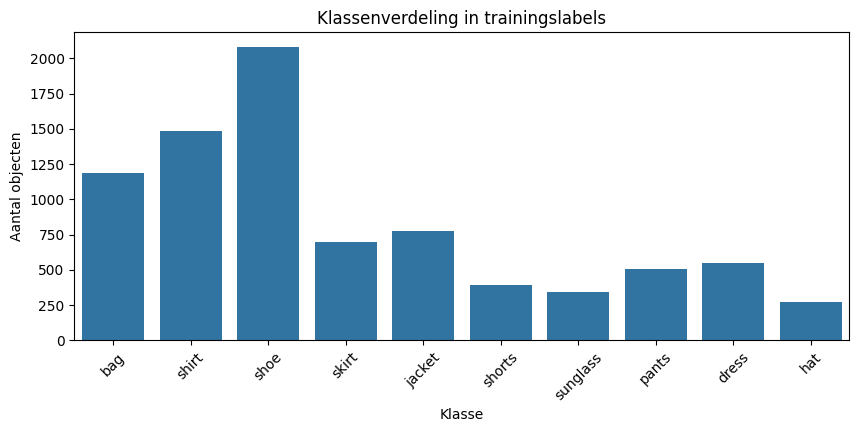

In [ ]:
def analyseer_klassenverdeling(label_dir):
    counter = Counter()
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    counter[class_id] += 1
    return counter


verdeling = analyseer_klassenverdeling(labels_dir)

# Visualiseren
plt.figure(figsize=(10, 4))
sns.barplot(x=[class_dict[k] for k in verdeling.keys()], y=list(verdeling.values()))
plt.title("Klassenverdeling in trainingslabels")
plt.ylabel("Aantal objecten")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.show()


De staafdiagram laat zien hoe de objectklassen verdeeld zijn in de trainingslabels. Op de x-as staan de klassen en op de y-as het aantal objecten per klasse.

Schoenen komen het meest voor, met meer dan 2000 objecten. Daarna komen shirts met ongeveer 1500 objecten, gevolgd door tassen met 1200. Jassen en rokken hebben elk tussen de 700 en 800 objecten. Broeken en jurken hebben ongeveer 500 objecten. Korte broeken en zonnebrillen zijn minder vaak aanwezig, met ongeveer 350 en 300 objecten. Hoeden komen het minst voor, iets meer dan 250 keer.

De staafdiagram laat duidelijk zien dat de verdeling van klassen ongelijk is. Dit noemen we een ongebalanceerde dataset. Dat kan invloed hebben op het trainen van een model. Het model leert dan beter de veelvoorkomende klassen te herkennen en minder goed de zeldzame.

### H&M Dataset

#### Voorbeeld afbeeldingen

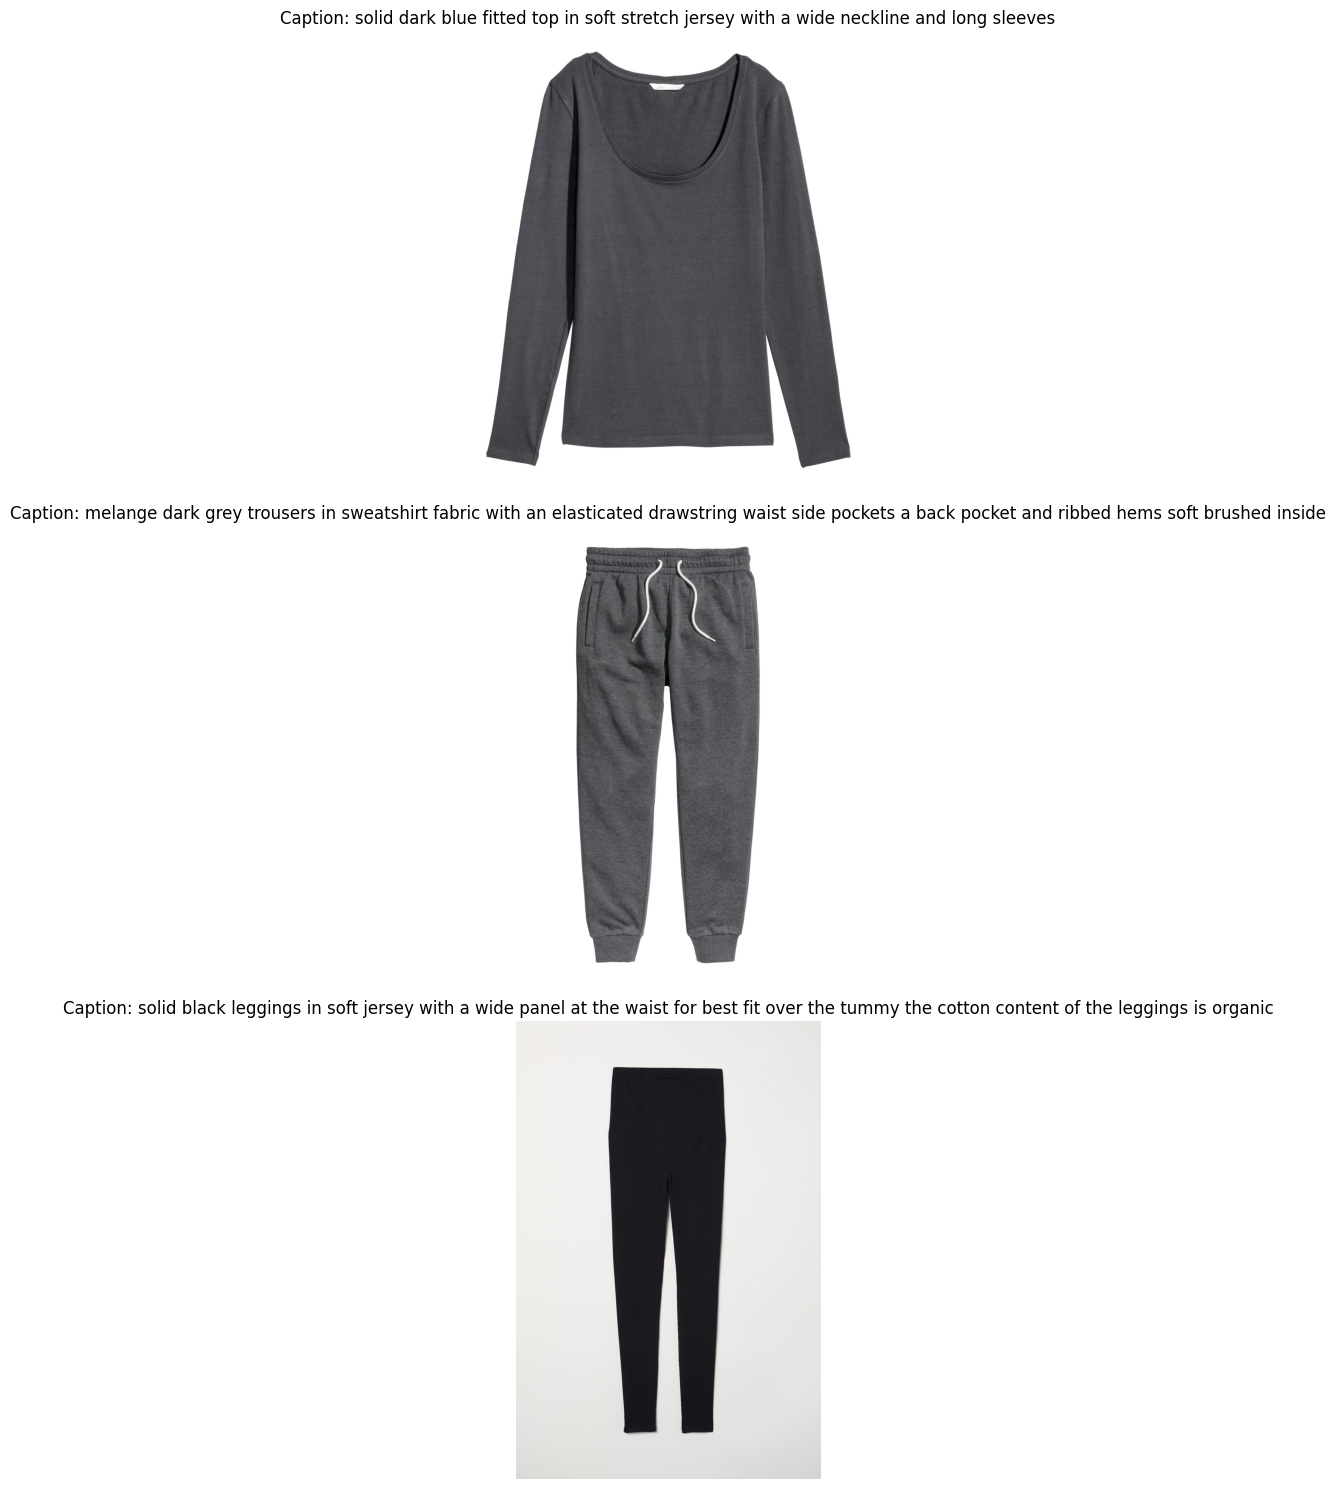

In [ ]:
# Selecteer een subset van de data om weer te geven (bijv. de training split)
data_split = hnm_dataset['train']

# Definieer hoeveel voorbeelden je wilt zien
num_examples_to_show = 3

plt.figure(figsize=(10, 5 * num_examples_to_show))

# Loop door de geselecteerde voorbeelden en toon ze
for i in range(num_examples_to_show):
    # Haal een voorbeeld op
    example = data_split[i]

    # Toon de afbeelding
    plt.subplot(num_examples_to_show, 1, i + 1)
    # De afbeelding zit in de 'image' kolom en is een PIL Image object
    plt.imshow(example['image'])
    # Use 'text' instead of 'caption' to access the caption information
    plt.title(f"Caption: {example['text']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Data beschrijving

De H&M dataset bestaat uit een trainset met daarin de kolommen: text en image. De text geeft de bijbehorende beschrijving van de foto. Verder bestaat deze dataset uit 12437 rijen zonder lege waardes

In [ ]:
print(hnm_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 12437
    })
})


In [ ]:
print(f"Grootte van de train split: {len(hnm_dataset['train'])}")

Grootte van de train split: 12437


In [ ]:
# Check missende waardes
missing_values = {'text': 0, 'image': 0}
total_examples = len(hnm_dataset['train'])

for example in hnm_dataset['train']:
    if example['text'] is None:
        missing_values['text'] += 1
    if example['image'] is None:
        missing_values['image'] += 1

print("Aantal missende waardes per kolom in de train split:")
print(missing_values)
print(f"Totaal aantal voorbeelden: {total_examples}")

# Optionally, you can also check for empty strings in the 'text' column
empty_text_count = sum(1 for example in hnm_dataset['train'] if example['text'] == "")
print(f"Aantal lege strings in de 'text' kolom: {empty_text_count}")

Aantal missende waardes per kolom in de train split:
{'text': 0, 'image': 0}
Totaal aantal voorbeelden: 12437
Aantal lege strings in de 'text' kolom: 0


### Tekst-analyse

#### Verdeling van de caption lengtes

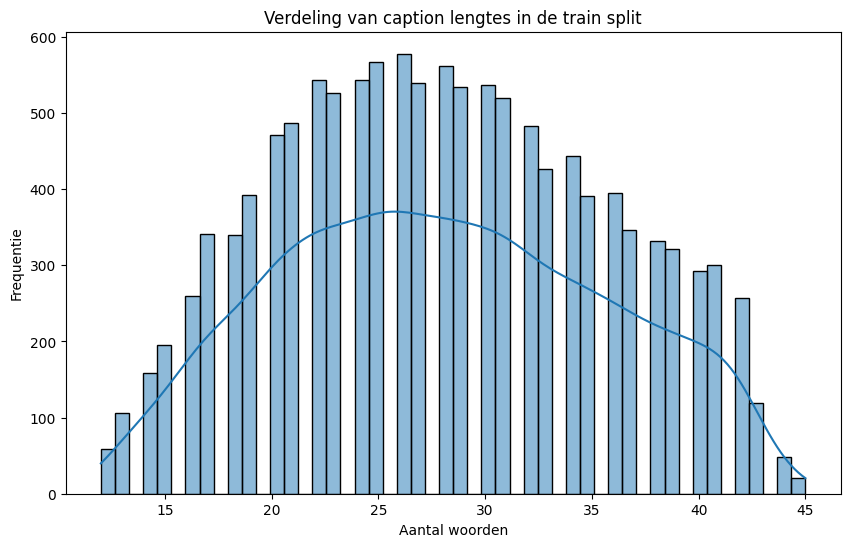

In [ ]:
caption_lengths = [len(example['text'].split()) for example in hnm_dataset['train']]

plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=50, kde=True)
plt.title("Verdeling van caption lengtes in de train split")
plt.xlabel("Aantal woorden")
plt.ylabel("Frequentie")
plt.show()

In deze grafiek is er sprake van een normale verdeling. De meeste captions bevatten een lengte tussen 20 en 30 woorden

Top 10 meest voorkomende woorden:
[('a', 21431), ('and', 19752), ('with', 19069), ('the', 17791), ('in', 13837), ('at', 11041), ('solid', 6805), ('sleeves', 5387), ('front', 4953), ('back', 4750)]


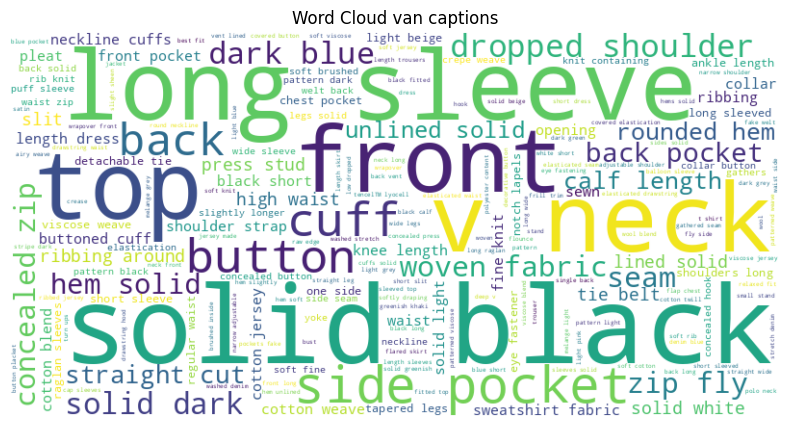

In [ ]:
from collections import Counter
from wordcloud import WordCloud

all_captions = " ".join([example['text'] for example in hnm_dataset['train']])
words = all_captions.split()
word_counts = Counter(words)

# Toon de top N meest voorkomende woorden
n_most_common = 10
print(f"Top {n_most_common} meest voorkomende woorden:")
print(word_counts.most_common(n_most_common))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_captions)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud van captions")
plt.show()

In deze afbeelding is er een duidelijk overzicht over de meest voorkomende woorden. Het blijkt dat Long Sleeve, Top, Front, V neck en Solid Black uitsteken. Dit kan ervoor zorgen dat als je een image wilt voorspellen met een van deze woorden in de caption, dat het een grote kans heeft om de juiste afbeelding te genereren.

#### Voorbeeldafbeeldingen met kleurverdeling

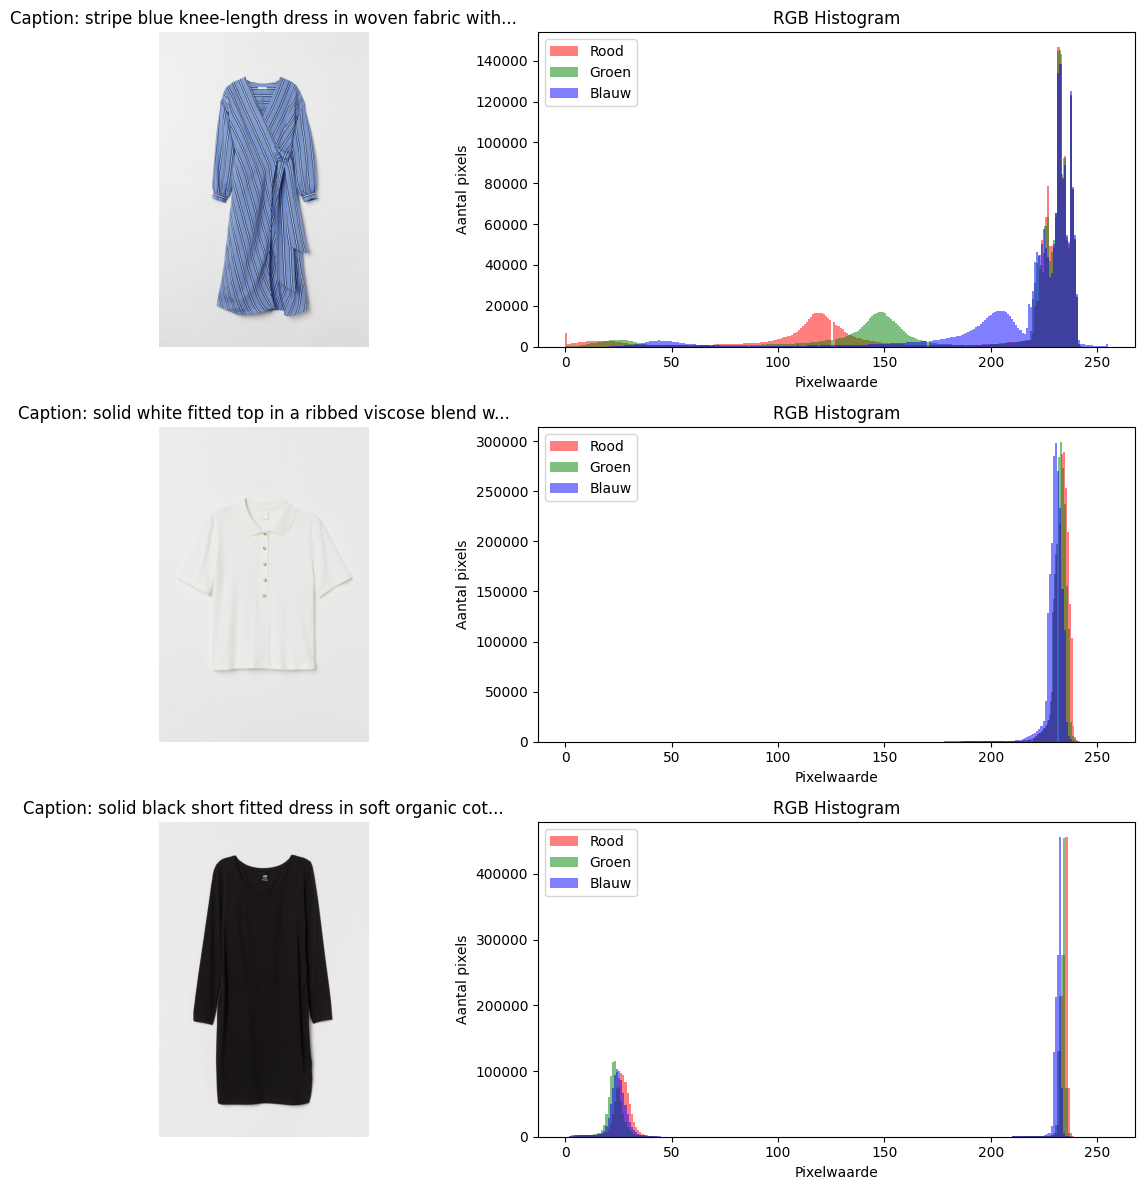

In [ ]:
# Kies willekeurige indexen
random_indices = random.sample(range(len(data_split)), num_examples_to_show)

plt.figure(figsize=(12, 4 * num_examples_to_show))

for i, index in enumerate(random_indices):
    # Haal een voorbeeld op basis van de willekeurige index
    example = data_split[index]

    # Haal de afbeelding en de caption op
    img_pil = example['image']
    caption = example['text']

    # Converteer de PIL Image naar een NumPy array (RGB formaat)
    img_np = np.array(img_pil)

    # Splits de kanalen
    # NumPy arrays zijn standaard HxWxChannels, dus R, G, B zijn de laatste dimensie
    r = img_np[:, :, 0]
    g = img_np[:, :, 1]
    b = img_np[:, :, 2]

    # Toon afbeelding
    plt.subplot(num_examples_to_show, 2, i*2 + 1)
    plt.imshow(img_np) # plt.imshow werkt met NumPy arrays (RGB)
    plt.title(f"Caption: {caption[:50]}...") # Toon een deel van de caption
    plt.axis('off')

    # Toon histogram
    plt.subplot(num_examples_to_show, 2, i*2 + 2)
    plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
    plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
    plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
    plt.title("RGB Histogram")
    plt.xlabel("Pixelwaarde")
    plt.ylabel("Aantal pixels")
    plt.legend()

plt.tight_layout()
plt.show()

Er blijkt een hoge consistente pixelwaarde rond de 225 te zijn in elke foto. Dit kan zijn omdat elke foto dezelfde achtergrond heeft. Alleen de kleur van de item verschilt dus per foto.

### Gemeenschappelijke items

We gebruiken SpaCy om automatisch zelfstandige naamwoorden uit de captions te halen. SpaCy herkent woordsoorten (zoals "dress", "bag", enz.) én zet woorden om naar hun basisvorm (bijv. "shoes" → "shoe"). Dit maakt de vergelijking met de objectdetectielabels betrouwbaarder en consistenter dan simpelweg losse woorden tellen.

In [ ]:
### Gemeenschappelijke items
labels_detectie = list(class_dict.values())
# SpaCy-model
nlp = spacy.load("en_core_web_sm")

caption_nouns = set()
for i in range(1000):
    row = data_split[i]
    doc = nlp(row["text"])
    caption_nouns.update([token.lemma_.lower() for token in doc if token.pos_ == "NOUN"])
detectie_set = set(labels_detectie)

# overlap
gemeenschappelijk = detectie_set.intersection(caption_nouns)

print("Gemeenschappelijke items:", gemeenschappelijk)

niet_gevonden = detectie_set - caption_nouns
print("Niet gevonden in captions:", niet_gevonden)

Gemeenschappelijke items: {'shirt', 'jacket', 'skirt', 'dress', 'bag'}
Niet gevonden in captions: {'pants', 'shorts', 'hat', 'shoe', 'sunglass'}


### Bevindingen EDA

De H&M dataset is een grote dataset met daarin captions die ongeveer 12 tot 45 woorden bevatten. De foto's van deze dataset hebben allemaal dezelfde achtergrond, waarvan alleen de item verschilt in kleur.

## Feature Engineering

## Modeling

### Objectdetectie

In [ ]:
# import os
# import shutil
# import random

# random.seed(42)

# # Originele train folders
# images_dir = f"{img_train}/images"
# labels_dir = f"{img_train}/labels"

# dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/'
# # Nieuwe mappen voor split
# train_images_dir = f'{dir}train/images'
# train_labels_dir = f'{dir}train/labels'
# val_images_dir = f'{dir}val/images'
# val_labels_dir = f'{dir}val/labels'

# os.makedirs(train_images_dir, exist_ok=True)
# os.makedirs(train_labels_dir, exist_ok=True)
# os.makedirs(val_images_dir, exist_ok=True)
# os.makedirs(val_labels_dir, exist_ok=True)

# # Alle afbeeldingen in train
# all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# # Shuffle en split 80% train, 20% val
# random.shuffle(all_images)
# split_idx = int(len(all_images)*0.8)
# train_images = all_images[:split_idx]
# val_images = all_images[split_idx:]

# # Functie om bestanden te kopiëren
# def copy_files(file_list, src_images, src_labels, dst_images, dst_labels):
#     for file_name in file_list:
#         # kopieer afbeelding
#         shutil.copy(os.path.join(src_images, file_name), os.path.join(dst_images, file_name))
#         # kopieer label (zelfde naam maar .txt extensie)
#         label_name = os.path.splitext(file_name)[0] + '.txt'
#         shutil.copy(os.path.join(src_labels, label_name), os.path.join(dst_labels, label_name))

# # Kopieer train bestanden
# copy_files(train_images, images_dir, labels_dir, train_images_dir, train_labels_dir)
# # Kopieer val bestanden
# copy_files(val_images, images_dir, labels_dir, val_images_dir, val_labels_dir)


In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.58 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.


In [ ]:
# Installeer dependencies van YOLOv5 (alleen nodig bij eerste keer)
%cd yolov5
!pip install -r requirements.txt
%cd ..


/content/yolov5
/content


In [ ]:
# Pad naar het data.yaml bestand in de Colab-omgeving
yaml_file_path = '/content/data.yaml'

# Inhoud van het data.yaml bestand
yaml_content = """
train: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/images
val: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images


nc: 10
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']

"""

# Schrijf de inhoud naar het bestand
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"'{yaml_file_path}' is aangepast.")

'/content/data.yaml' is aangepast.


In [ ]:
!python /content/yolov5/train.py --data /content/data.yaml --weights yolov5m.pt --img 640 --epochs 50 --batch-size 32

Streaminguitvoer ingekort tot de laatste 5000 regels.
       5/49      12.7G    0.04422    0.03955    0.01525        244        640:  96% 52/54 [00:52<00:02,  1.10s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/49      12.7G    0.04419    0.03958    0.01524        242        640:  98% 53/54 [00:54<00:01,  1.38s/it]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       5/49      12.7G    0.04428    0.03944    0.01529        112        640: 100% 54/54 [00:54<00:00,  1.02s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 7/7 [00:07<00:00,  1.03s/it]
                   all        429       1680      0.647      0.732       0.71      0.356

      Epo

In [ ]:
!python /content/yolov5/detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images" \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --project /content/yolov5/runs/detect \
  --name test_predictions \
  --exist-ok


detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/runs/detect, name=test_predictions, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-419-gcd44191c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
image 1/537 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images/10084.jpg: 640x448 1 jacket, 2 shirts, 1 skirt, 1 bag, 1 shoe, 46.6ms
image 2/537 /content/drive/MyDrive/Colab Notebooks/Portfo

In [ ]:
import os
import glob
import torch
import pandas as pd
from PIL import Image


# Zoek automatisch het pad naar best.pt (laatste experiment)
runs_dir = '/content/yolov5/runs/train'
list_of_runs = glob.glob(f'{runs_dir}/exp*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# Laad het getrainde YOLOv5-model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)
model.eval()  # Belangrijk voor evaluatie (geen dropout, batchnorm in eval mode)

# Pad naar testafbeeldingen en output-CSV
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/submission.csv'

# Functie om voorspellingen te maken en te formatteren
def predict_model(image_path):
    results = model(image_path)
    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    if results.pred is not None and len(results.pred) > 0:
        for *box, conf, cls in results.pred[0].tolist():
            xmin, ymin, xmax, ymax = box
            cx = (xmin + xmax) / 2 / w_img
            cy = (ymin + ymax) / 2 / h_img
            bw = (xmax - xmin) / w_img
            bh = (ymax - ymin) / h_img
            preds.extend([
                int(cls),
                round(conf, 4),
                round(cx, 6),
                round(cy, 6),
                round(bw, 6),
                round(bh, 6)
            ])
    return preds

# Verwerk alle testafbeeldingen en maak predictions
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    # Formatteer als comma-separated string in lijstnotatie: [0,0.99,0.5,...]
    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    # Verwijder de extensie (.jpg) voor de id-kolom
    image_id = os.path.splitext(img_name)[0]

    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# Maak en exporteer de CSV
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-31 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/

Submission bestand opgeslagen in: /content/submission.csv


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

In [ ]:
# Pad naar jouw training run
results_csv_path1 = '/content/yolov5/runs/train/exp/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path1)

df.tail()

epoch     train/box_loss     train/obj_loss  \
45                 45           0.022053           0.025312   
46                 46           0.021721           0.025290   
47                 47           0.021394           0.025133   
48                 48           0.021204           0.024246   
49                 49           0.020929           0.024825   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
45           0.004646            0.79722  ...           0.036810   
46           0.004534            0.80641  ...           0.037603   
47           0.004483            0.78753  ...           0.037320   
48           0.004605            0.79421  ...           0.037391   
49           0.004349            0.80502  ...           0.037277   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
45           0.008673           0.001288           0.001288           0.001288  
46           0.008762           0.001090           0.001090           0.001090  
47           0.008938           0.000892           0.000892           0.000892  
48           0.009019           0.000694           0.000694           0.000694  
49           0.008830           0.000496           0.000496           0.000496  

[5 rows x 14 columns]

25 epochs

In [ ]:
# Pad naar jouw training run
results_csv_path = '/content/yolov5/runs/train/exp2/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path)

df

epoch     train/box_loss     train/obj_loss  \
0                   0           0.083021           0.063074   
1                   1           0.062982           0.048551   
2                   2           0.060614           0.043917   
3                   3           0.053233           0.041145   
4                   4           0.047312           0.041063   
5                   5           0.044323           0.039697   
6                   6           0.041640           0.039658   
7                   7           0.040094           0.038000   
8                   8           0.038963           0.038233   
9                   9           0.037802           0.037513   
10                 10           0.036339           0.037181   
11                 11           0.036021           0.036083   
12                 12           0.035268           0.036777   
13                 13           0.033867           0.035971   
14                 14           0.033242           0.035409   
15                 15           0.032951           0.034902   
16                 16           0.031576           0.034442   
17                 17           0.030982           0.033313   
18                 18           0.030368           0.032720   
19                 19           0.029494           0.032578   
20                 20           0.028577           0.031599   
21                 21           0.028198           0.030996   
22                 22           0.027858           0.030998   
23                 23           0.027280           0.030589   
24                 24           0.026108           0.029812   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
0            0.052098            0.42729  ...           0.051379   
1            0.032132            0.47028  ...           0.034036   
2            0.025677            0.39751  ...           0.032999   
3            0.020788            0.46190  ...           0.031942   
4            0.017501            0.62073  ...           0.032653   
5            0.015065            0.63302  ...           0.034212   
6            0.013754            0.72570  ...           0.032997   
7            0.012406            0.72650  ...           0.032033   
8            0.012223            0.73050  ...           0.032354   
9            0.011545            0.72574  ...           0.032543   
10           0.010631            0.72216  ...           0.032612   
11           0.010633            0.75170  ...           0.032688   
12           0.010065            0.73521  ...           0.032786   
13           0.009579            0.76674  ...           0.032541   
14           0.009350            0.75021  ...           0.032054   
15           0.008923            0.75114  ...           0.031879   
16           0.008367            0.76203  ...           0.032593   
17           0.008206            0.74715  ...           0.032776   
18           0.007690            0.75059  ...           0.033081   
19           0.007427            0.76101  ...           0.033287   
20           0.007300            0.75660  ...           0.032377   
21           0.007267            0.76099  ...           0.032773   
22           0.006644            0.75753  ...           0.033500   
23           0.006636            0.77103  ...           0.032943   
24           0.006272            0.76332  ...           0.033328   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
0            0.033125           0.070556           0.003272           0.003272  
1            0.022291           0.040294           0.006343           0.006343  
2            0.017266           0.009768           0.009151           0.009151  
3            0.013786           0.008812           0.008812           0.008812  
4            0.012121           0.008812           0.008812           0.008812  
5            0.011512           0.008416           0.008416           0.008416  
6            0.009950           0.008020 

### Ondertiteling van afbeeldingen

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
import requests
from PIL import Image
import io
import numpy as np
import tensorflow as tf

# Dataset laden
# hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")

hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")['train']

hnm_dataset = hnm_dataset.train_test_split(test_size=0.2, seed=42)

IMG_HEIGHT = 256
IMG_WIDTH = 256
MAX_LENGTH = 20
VOCAB_SIZE = 5000

# Voeg <start> en <end> tokens toe aan captions
captions = ['<start> ' + ex['text'] + ' <end>' for ex in hnm_dataset['train']]
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(captions)
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [8]:
import numpy as np
import tensorflow as tf
from PIL import Image

def process_hnm_example(example):
    img = example['image']
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    img = Image.fromarray(img).resize((IMG_WIDTH, IMG_HEIGHT)).convert('RGB')
    img_np = np.array(img)
    img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)
    img_tensor = (img_tensor / 127.5) - 1
    caption = '<start> ' + example['text'] + ' <end>'
    return img_tensor, caption

def encode_caption(caption):
    seq = tokenizer.texts_to_sequences([caption.numpy().decode()])[0]
    seq = pad_sequences([seq], maxlen=MAX_LENGTH, padding='post')[0]
    return seq

def tf_encode_caption(caption):
    return tf.py_function(encode_caption, [caption], tf.int32)

def map_func(img, cap):
    cap_seq = tf_encode_caption(cap)
    cap_seq.set_shape([MAX_LENGTH])
    input_seq = cap_seq[:-1]
    target_seq = cap_seq[1:]
    input_seq.set_shape([MAX_LENGTH-1])
    target_seq.set_shape([MAX_LENGTH-1])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return (img, input_seq), target_seq

def gen_hnm_examples(split='train'):
    for example in hnm_dataset[split]:
        yield process_hnm_example(example)

In [9]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_generator(
    lambda: gen_hnm_examples('train'),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
).map(map_func).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: gen_hnm_examples('test'),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
).map(map_func).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras import layers, Model

def build_model():
    # Encoder
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(256,256,3), pooling='avg')
    base_model.trainable = False
    img_input = layers.Input(shape=(256,256,3))
    features = base_model(img_input)
    features = layers.Dense(256, activation='relu')(features)

    # Decoder
    cap_input = layers.Input(shape=(MAX_LENGTH-1,))
    x = layers.Embedding(VOCAB_SIZE, 256, mask_zero=True)(cap_input)
    x = layers.LSTM(256, return_sequences=True)(x, initial_state=[features, features])
    output = layers.Dense(VOCAB_SIZE, activation='softmax')(x)

    return Model([img_input, cap_input], output)

model = build_model()

<ipython-input-10-1669507878>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(256,256,3), pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# showmodel
model = build_model()
model.summary()

<ipython-input-10-1669507878>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(256,256,3), pooling='avg')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 19, 256)   │    307,456 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    327,936 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 19, 256)   │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 19, 1201)  │    308,657 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,727,345 (14.22 MB)

 Trainable params: 1,469,361 (5.61 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [14]:
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

In [15]:
steps_per_epoch = len(hnm_dataset['train']) // BATCH_SIZE
validation_steps = len(hnm_dataset['test']) // BATCH_SIZE

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.5286 - loss: 2.2236 - val_accuracy: 0.5844 - val_loss: 1.8908
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6041 - loss: 1.7697 - val_accuracy: 0.6191 - val_loss: 1.6879
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6353 - loss: 1.5704 - val_accuracy: 0.6342 - val_loss: 1.5878
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.6535 - loss: 1.4563 - val_accuracy: 0.6425 - val_loss: 1.5274
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.6672 - loss: 1.3705 - val_accuracy: 0.6510 - val_loss: 1.4791
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.6790 - loss: 1.3056 - val_accuracy: 0.6567 - val_loss: 1.4475
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.6904 - loss: 1.2475 - val_accuracy: 0.6598 - val_loss: 1.4266
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.6990 - loss: 1.1964 - val_accu

In [37]:
hnm_dataset['test']

Dataset({
    features: ['text', 'image'],
    num_rows: 2488
})

In [21]:
# Export model in .pt
model.save("image_captioning_model.keras")

In [22]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [23]:
# Download de folder /content/caption_model
!zip -r /content/caption_model.zip /content/caption_model

  adding: content/caption_model/ (stored 0%)
  adding: content/caption_model/variables/ (stored 0%)
  adding: content/caption_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/caption_model/variables/variables.index (deflated 78%)
  adding: content/caption_model/saved_model.pb (deflated 91%)
  adding: content/caption_model/fingerprint.pb (stored 0%)
  adding: content/caption_model/assets/ (stored 0%)


In [40]:
def generate_caption(image, tokenizer, model, max_length=20):
    input_seq = [tokenizer.word_index['start']]
    for _ in range(max_length):
        seq = pad_sequences([input_seq], maxlen=max_length-1, padding='post')
        preds = model.predict([image[None, ...], seq], verbose=0)
        next_id = np.argmax(preds[0, -1])
        print("Predicted token id:", next_id, "->", tokenizer.index_word.get(next_id, ''))
        if next_id == tokenizer.word_index.get('end', -1):
            break
        input_seq.append(next_id)
    words = [tokenizer.index_word.get(i, '') for i in input_seq[1:]]
    return ' '.join(words)

example = next(iter(hnm_dataset['test']))
img_tensor, _ = process_hnm_example(example)
caption = generate_caption(img_tensor.numpy(), tokenizer, model)
print("Generated caption:", caption)

Predicted token id: 7 -> end
Generated caption: 


In [44]:
import matplotlib.pyplot as plt

def generate_caption(image, tokenizer, model, max_length=20, temperature=1.0, show_image=True):
    if show_image:
        img_np = (image + 1) / 2  # terug naar [0, 1]
        plt.imshow(img_np)
        plt.axis('off')
        plt.title("Input image")
        plt.show()
    input_seq = [tokenizer.word_index['start']]
    for _ in range(max_length):
        seq = pad_sequences([input_seq], maxlen=max_length-1, padding='post')
        preds = model.predict([image[None, ...], seq], verbose=0)
        logits = preds[0, -1]
        logits = logits / temperature
        probs = np.exp(logits) / np.sum(np.exp(logits))
        next_id = np.random.choice(len(probs), p=probs)
        if next_id == tokenizer.word_index.get('end', -1):
            break
        input_seq.append(next_id)
    words = [tokenizer.index_word.get(i, '') for i in input_seq[1:]]
    return ' '.join(words)

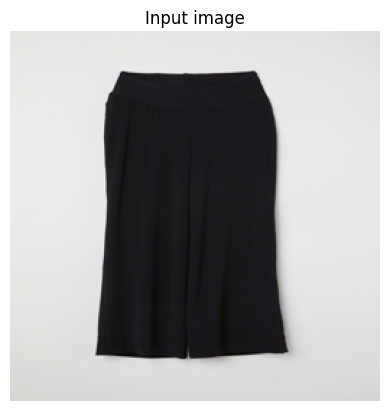

Generated caption: removed v anna flexible tube shearling discreetly costume after embrace chinos breasted details stud styled metallic chin yoke stitches multiple


In [46]:
caption = generate_caption(img_tensor.numpy(), tokenizer, model, temperature=0.8, show_image=True)
print("Generated caption:", caption)

### Beeldgeneratie

### Implementatie

### Scoren:

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

#### Bevindingen modellen

## Conclusion & Advice

## Sources

### Submission functie

In [ ]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [ ]:
# create_submission(y_pred, df_test, 'test.csv', le)

filename    genre
0    test.00000.wav     rock
1    test.00001.wav  country
2    test.00002.wav      pop
3    test.00003.wav    blues
4    test.00004.wav  country
..              ...      ...
124  test.00124.wav   reggae
125  test.00125.wav  country
126  test.00126.wav   hiphop
127  test.00127.wav  country
128  test.00128.wav      pop

[129 rows x 2 columns]

In [4]:
# Dataset laden en splitsen
hnm_dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k")['train']
hnm_dataset = hnm_dataset.train_test_split(test_size=0.2, seed=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/323 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12437 [00:00<?, ? examples/s]

In [30]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
MAX_LENGTH = 20
VOCAB_SIZE = 5000

# captions = ['<start> ' + ex['text'] + ' <end>' for ex in hnm_dataset['train']]
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
# tokenizer.fit_on_texts(captions)
# VOCAB_SIZE = len(tokenizer.word_index) + 1

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def process_hnm_example(example):
    img = example['image']
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    img = Image.fromarray(img).resize((IMG_WIDTH, IMG_HEIGHT)).convert('RGB')
    img_np = np.array(img)
    img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)
    img_tensor = data_augmentation(img_tensor)
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(img_tensor)  # [-1,1]
    caption = '<start> ' + example['text'] + ' <end>'
    return img_tensor, caption

def encode_caption(caption):
    seq = tokenizer.texts_to_sequences([caption.numpy().decode()])[0]
    seq = tf.keras.preprocessing.sequence.pad_sequences([seq], maxlen=MAX_LENGTH, padding='post')[0]
    return seq

def tf_encode_caption(caption):
    return tf.py_function(encode_caption, [caption], tf.int32)

def map_func(img, cap):
    cap_seq = tf_encode_caption(cap)
    cap_seq.set_shape([MAX_LENGTH])
    input_seq = cap_seq[:-1]
    target_seq = cap_seq[1:]
    input_seq.set_shape([MAX_LENGTH-1])
    target_seq.set_shape([MAX_LENGTH-1])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    return (img, input_seq), target_seq

def gen_hnm_examples(split='train'):
    for example in hnm_dataset[split]:
        yield process_hnm_example(example)

In [34]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: gen_hnm_examples('train'),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
).map(map_func).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: gen_hnm_examples('test'),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.string)
    )
).map(map_func).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [35]:
from tensorflow.keras.applications import EfficientNetB0

def build_cnn_encoder(img_shape=(256, 256, 3), embed_dim=256):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_shape, pooling='avg')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=img_shape)
    x = base_model(inputs)
    x = tf.keras.layers.Dense(embed_dim)(x)
    return tf.keras.Model(inputs, x, name="cnn_encoder")

In [36]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, Input, Layer

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training):
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [37]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, vocab_size, max_len, rate=0.1):
        super().__init__()
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.pos_embed = tf.keras.layers.Embedding(max_len, embed_dim)
        self.att1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)
        self.final = Dense(vocab_size)

    def call(self, x, enc_output, training):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        x = self.embed(x) + self.pos_embed(positions)
        attn1 = self.att1(x, x)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)
        attn2 = self.att2(out1, enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        return self.final(out3)

In [38]:
def build_captioning_model(img_shape, vocab_size, max_len, embed_dim=256, num_heads=4, ff_dim=512):
    img_inputs = Input(shape=img_shape)
    seq_inputs = Input(shape=(max_len-1,))
    # Encoder
    cnn_encoder = build_cnn_encoder(img_shape, embed_dim)
    img_features = cnn_encoder(img_inputs)
    img_features = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 1))(img_features)
    transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim)
    enc_output = transformer_encoder(img_features, training=True)
    # Decoder
    transformer_decoder = TransformerDecoder(embed_dim, num_heads, ff_dim, vocab_size, max_len)
    dec_output = transformer_decoder(seq_inputs, enc_output, training=True)
    return tf.keras.Model([img_inputs, seq_inputs], dec_output)

In [39]:
model = build_captioning_model(
    img_shape=(256,256,3),
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LENGTH,
    embed_dim=256,
    num_heads=4,
    ff_dim=512
)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Gebruik je bestaande tf.data pipeline en model.fit!

In [40]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_encoder         │ (None, 256)       │  4,377,507 │ input_layer_14[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 256)    │          0 │ cnn_encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 1, 256)    │  1,315,840 │ lambda_2[0][0]    │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, 19, 5000)  │  4,938,376 │ input_layer_15[0… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,631,723 (40.56 MB)

 Trainable params: 6,582,152 (25.11 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [41]:
steps_per_epoch = len(hnm_dataset['train']) // BATCH_SIZE
validation_steps = len(hnm_dataset['test']) // BATCH_SIZE

train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

In [42]:

# Stel je tf.data pipeline levert ((img, input_seq), target_seq)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.0544 - loss: 7.8917 - val_accuracy: 0.0017 - val_loss: 8.5172
Epoch 2/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 823s 3s/step - accuracy: 0.0029 - loss: 8.5173 - val_accuracy: 0.0000e+00 - val_loss: 8.5172
Epoch 3/3
310/310 ━━━━━━━━━━━━━━━━━━━━ 770s 2s/step - accuracy: 0.0019 - loss: 8.5172 - val_accuracy: 0.0000e+00 - val_loss: 8.5172


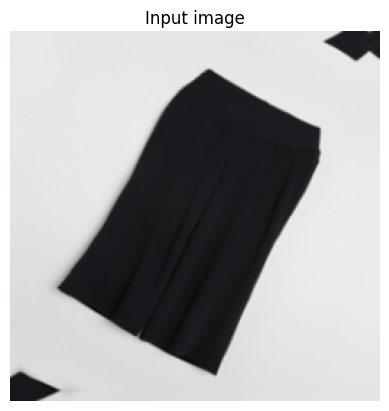

Generated caption:  ball           bellowed      boucle 


In [48]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(image, tokenizer, model, max_length=20, temperature=1.0, show_image=True):
    if show_image:
        img_np = (image + 1) / 2  # terug naar [0, 1]
        plt.imshow(img_np)
        plt.axis('off')
        plt.title("Input image")
        plt.show()
    input_seq = [tokenizer.word_index['start']]
    for _ in range(max_length):
        seq = pad_sequences([input_seq], maxlen=max_length-1, padding='post')
        preds = model.predict([image[None, ...], seq], verbose=0)
        logits = preds[0, -1]
        logits = logits / temperature
        probs = np.exp(logits) / np.sum(np.exp(logits))
        next_id = np.random.choice(len(probs), p=probs)
        if next_id == tokenizer.word_index.get('end', -1):
            break
        input_seq.append(next_id)
    words = [tokenizer.index_word.get(i, '') for i in input_seq[1:]]
    return ' '.join(words)

example = next(iter(hnm_dataset['test']))
img_tensor, _ = process_hnm_example(example)
caption = generate_caption(img_tensor.numpy(), tokenizer, model, temperature=1.0)
print("Generated caption:", caption)

In [49]:
print('start' in tokenizer.word_index)  # Moet True zijn
print('end' in tokenizer.word_index)    # Moet True zijn
print(tokenizer.word_index.get('start'))  # Moet een integer zijn
print(tokenizer.word_index.get('end'))    # Moet een integer zijn

True
True
8
7


In [50]:
for (img, input_seq), target_seq in train_dataset.take(1):
    print("Input seq:", input_seq[0].numpy())
    print("Target seq:", target_seq[0].numpy())
    print("Input tokens:", [tokenizer.index_word.get(i, '') for i in input_seq[0].numpy()])
    print("Target tokens:", [tokenizer.index_word.get(i, '') for i in target_seq[0].numpy()])


Input seq: [  3  39   9   5  18  14  11  61 167 220  99  19   3 417 175   5  20 205
  36]
Target seq: [ 39   9   5  18  14  11  61 167 220  99  19   3 417 175   5  20 205  36
   7]
Input tokens: ['and', 'buttons', 'at', 'the', 'top', 'long', 'sleeves', 'narrow', 'frill', 'trimmed', 'buttoned', 'cuffs', 'and', 'tiers', 'to', 'the', 'hem', 'partly', 'lined']
Target tokens: ['buttons', 'at', 'the', 'top', 'long', 'sleeves', 'narrow', 'frill', 'trimmed', 'buttoned', 'cuffs', 'and', 'tiers', 'to', 'the', 'hem', 'partly', 'lined', 'end']


### Html

In [ ]:
# Upload ipynb
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>